# GPS reassign to UAV images

In paper Section 3.2.3.3. Assessment on turbidity retrieval performance (UAV Images): GPS-based stitching algorithm

In [7]:
import os
from os.path import join
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
# read the image
line_image_fp = r'C:\Users\SZEERN\OneDrive - Nanyang Technological University\YoongSze\Results_DIP&DSTT_DroneImage_inpainted\CENSORED_DSTT_LINE10'
input_imgs = os.listdir(line_image_fp) 

print(input_imgs)

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg']


In [8]:
# read the gps
line_gps_txt_fp = r'C:\Users\SZEERN\OneDrive - Nanyang Technological University\YoongSze\DroneImageSequence_normalized\LineGPS\Line9.txt'
with open(line_gps_txt_fp,'r') as gps_input:
    gps = [line for line in gps_input]

coords = []
for line in gps:
    lat, lon = float(line.split(' ')[0]), float(line.split(' ')[1])
    coords.append((lat,lon))
    
print(len(coords))

33


In [9]:
class Haversine:
    '''
    use the haversine class to calculate the distance between
    two lon/lat coordnate pairs.
    output distance available in kilometers, meters, miles, and feet.
    example usage: Haversine([lon1,lat1],[lon2,lat2]).feet
    
    '''
    def __init__(self,coord1,coord2):
        lon1,lat1=coord1
        lon2,lat2=coord2
        
        R=6371000                               # radius of Earth in meters
        phi_1=math.radians(lat1)
        phi_2=math.radians(lat2)

        delta_phi=math.radians(lat2-lat1)
        delta_lambda=math.radians(lon2-lon1)

        a=math.sin(delta_phi/2.0)**2+\
           math.cos(phi_1)*math.cos(phi_2)*\
           math.sin(delta_lambda/2.0)**2
        c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
        
        self.meters=R*c                         # output distance in meters
        self.km=self.meters/1000.0              # output distance in kilometers
        self.miles=self.meters*0.000621371      # output distance in miles
        self.feet=self.miles*5280               # output distance in feet

def calculate_overlap_ratio(start_coords,end_coords, n_images, height):
        """
        image_index_start (int)
        image_index_end (int)
        unique_gps_df : dataframe contains flight parameter for all image including lat,long,height, and timestamp
        """
        # print("Getting overlap ratio...")
        focal_length = 5.4 #mm
        actual_size_of_sensor_front = 3.6 #mm
        fov_front = 2*math.atan(actual_size_of_sensor_front/2/focal_length)*180/math.pi #deg
        total_gnd_coverage_front = 2*height*math.tan(math.pi*fov_front/2/180) #metres #angle is converted to radians first
        print('Frontal ground coverage of one image: {:3f} m'.format(total_gnd_coverage_front))
        
        #Calculate distance between start and end points
        combined_coords = np.transpose(np.array([start_coords,end_coords])) #1=latitude, 2=longitude
        lat = combined_coords[0,:] #list of latitude, lat[0] = lat_start
        lon = combined_coords[1,:] #list of lon
        
        gps_start = (lat[0],lon[0])
        gps_stop = (lat[1],lon[1])
        dist = Haversine(gps_start,gps_stop).meters
               
        #Calculate overlap ratio based on distance and ground coverage only
        overlap_front = total_gnd_coverage_front - (dist/(n_images-1))
        overlap_front_ratio = overlap_front/total_gnd_coverage_front
        
        return overlap_front_ratio

In [10]:
#calculate overlap ratio of the line
OR_x = calculate_overlap_ratio(coords[0],coords[-1],n_images=34,height=60) * 100
print('Line overlap ratio: {:2f}%'.format(OR_x))

Frontal ground coverage of one image: 40.000000 m
Line overlap ratio: 88.434362%


In [11]:
#stitch image
def raw_attributes(line_image_array):

        #timestamps = [gps_df.values[t,3] for t in range(start_index,end_index)]
        #timestamps = self.unique_gps_df.values[:,3] 
        #date_formatted = date.strftime('%m-%d-%Y')
        #timestamps = [date_formatted + '_' + t for t in timestamps]
        #dt = [datetime.strptime(t,'%H:%M:%S.%f') for t in timestamps]
    
        img_dict = {}
        for i in range(line_image_array.shape[0]):
            scene_image_array = line_image_array[i,:,:,:]
            #key is the name of the image file, value is the datetime
            img_dict[i] = {'raw_file':scene_image_array} #dt[i]
        return img_dict
    
def get_overlap_columns(band_width,overlap_x):
        """
        calculate overlap pixels across the images for the flight line. 
        >>>get_overlap_ratios_per_line()
        """
        
        overlap_x_ratio = overlap_x
        #print(overlap_x_ratio)
        if type(overlap_x_ratio) is list:
            overlapped_cols = [int(ratio/100*band_width) for ratio in overlap_x_ratio]
        else: #i.e., overlap is a number
            if overlap_x_ratio < 0: #or overlap_x_ratio > 1:
                print("Overlap_x_ratio < 0. Overlap ratio set as 0. Stitching will not be accurate!")
                overlap_x_ratio = 0
            elif overlap_x_ratio > 100:
                print("Overlap_x_ratio > 1. Overlap ratio set as 1. Stitching will not be accurate!")
                overlap_x_ratio = 1

            overlapped_cols = int(overlap_x_ratio/100*band_width)
        
        return overlapped_cols    

def trimm_image(image_array, band_width, overlap_x):
        """ 
        conduct linear blending for an image array
        inputs:
        image_array (list of np array): greyscale slices of a band
        overlap_ratios_of_the_line
            keys of the dictionaries are:
                image_frames_list: contains a list of image frame index, 
        """
        #print(overlap_x)
        overlapped_cols = get_overlap_columns(band_width, overlap_x)
        
        #print(overlapped_cols)
        trimmed_initial = [image_array[0]]
        
        if type(overlapped_cols) is list:
            trimmed_subsequent = [img[:,overlapped_cols[i]:band_width] for i, img in enumerate(image_array[1:])]
        else:
            trimmed_subsequent = [img[:,overlapped_cols:band_width] for img in image_array[1:]]
        
        trimmed_image_array = trimmed_initial+trimmed_subsequent
        stitched_img = np.hstack(trimmed_image_array)
          
        return stitched_img #if self.reverse is False else np.fliplr(np.flipud(stitched_img))
    
def get_stitched_img(line_image_array, overlap_x):
        """ 
        outputs band_list of stitched img in the form of a dictionary. keys are band number, values are image array
        >>>get_stitched_img()
        """
        raw_info = raw_attributes(line_image_array)
        band_width = line_image_array.shape[1]
        
        band_list = {} #store all the separate bands
        for i in range(3): 
            image_array = [] #uncorrected
            for (_,raw_attr) in raw_info.items(): #iterate across images
                f = raw_attr['raw_file']
                band_array = f[:,:,i]
                rotated_band_array = np.rot90(band_array,3)
                image_array.append(rotated_band_array)
            
            stitched_img = trimm_image(image_array, band_width, overlap_x)
            band_list[i] = stitched_img
            
        return band_list

Generating array of cropped image for line


<function matplotlib.pyplot.show(close=None, block=None)>

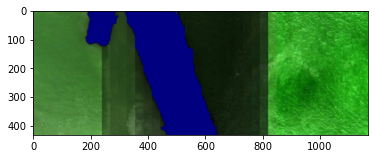

In [12]:
line_image_list = []
print('Generating array of cropped image for line')
for i in input_imgs: 
    img_fp = line_image_fp + '\\' + i
    im_aligned = cv2.imread(img_fp)
    #print(im_aligned.shape)
    line_image_list.append(im_aligned)
    line_image_array = np.asarray(line_image_list)
    
#raw_info = raw_attributes(line_image_array)
band_list = get_stitched_img(line_image_array=line_image_array, overlap_x=88)

r = band_list[0]
g = band_list[1]
b = band_list[2]
# #create the stacked arrays
stitched_rgb = np.dstack((r,g,b))
img = Image.fromarray((stitched_rgb).astype(np.uint8), mode='RGB')

plt.imshow(img)
plt.show



In [46]:
def read_sampling_data(sampling_fp): 

    sampling_df = pd.read_csv(sampling_fp, encoding='latin1', skiprows=8, index_col=0).dropna()
    sampling_df["datetime"] = pd.to_datetime(sampling_df["TimeUTC (HH:mm:ss)"]) + pd.to_timedelta(8, unit='h') #add 8 hours from UTC to Singapore zone

    tss_time = sampling_df["datetime"].tolist()
    tss_lat = sampling_df["Latitude"].tolist()
    tss_lon = sampling_df["Longitude"].tolist()
    tss_measurements = sampling_df["Turbidity FNU"].tolist()

    return tss_time, tss_lat, tss_lon, tss_measurements

def get_affine_transformation(stitched_img_array, angle_to_rotate):
    """
    this function only rotates the stitched image array and makes sure the bounding box are optimal
    inputs is the array of stitched multispectral image (shape H x W x 10), 
    angle_to_rotate (can be manually specified), but it's calculated from flight path angle. 
    Rotation is about the horizontal. +ve means rotate acw, -ve means rotate cw about horizontal
    mask (None or np.array): if none, no masking is conducted. if np.array of mask is provided, masking is conducted
    transform_predicted_image (boolean): whether to geotransform a predicted_image.
    classify (boolean): indicates whether different objects should be identified with a different colour
    """

    #-------PERFORM AFFINE TRANSFORMATION-----------
    rows, cols = stitched_img_array.shape[0],stitched_img_array.shape[1] #rgb image
    center = (cols//2,rows//2)

    # using cv2.getRotationMatrix2D() to get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center,angle_to_rotate,1) #center, angle, scale
    cosofRotationMatrix = np.abs(rotation_matrix[0][0]) #scale*cos(angle)
    sinofRotationMatrix = np.abs(rotation_matrix[0][1]) #scale*sin(angle)

    # warpAffine function to prevent cropping of image sides
    newImageHeight = int((cols * sinofRotationMatrix) + (rows * cosofRotationMatrix))
    newImageWidth = int((cols * cosofRotationMatrix) + (rows * sinofRotationMatrix))

    # After computing the new height & width of an image
    # we also need to update the values of rotation matrix
    rotation_matrix[0][2] += (newImageWidth/2) - center[0]
    rotation_matrix[1][2] += (newImageHeight/2) - center[1]

    # Now, we will perform actual image rotation WITHOUT MASK
    rotatingimage = cv2.warpAffine(stitched_img_array, rotation_matrix, (newImageWidth, newImageHeight))

    return rotatingimage

def get_reflectance_from_GPS(band_list, coords, line_image_array ,radius, sampling_fp, fp_spectral_info): #mask = None, glint_corrected_reflectance=None, preview=False
    """ 
    this function obtains the corrected reflectance of all wavelengths given the coordinates of TSS measurements
    transform the images based on transformation code in the geotransform function
    inputs are:
    fp_store (str): folderpath where images are stored
    line_number (int): flight path number
    test_gps_index (list of tuples): gps index output from GUI_flight_lines
    unique_gps_df: gps df from bayspec
    tss_lat, tss_lon, tss_mesasurements: corresponding information from water quality df (stored in a list)
    radius (int): extent of ROI (in integer)
    preview (boolean): plot graph of reflectance and corresponding location in image (Default = True)
    mask_corrupted_lines (boolean): Default = True
    mask_objects (boolean): Default = True
        if both mask_corrupted_lines & mask_objects == True, then mask_object_corrupted will be used to mask the images
        elif (mask_corrupted_lines == True and mask_objects == False), then only corrupted lines are masked
        elif (mask_corrupted_lines == False and mask_objects == True), then only objects are masked
        else (both mask_corrupted_lines & mask_objects == False), no masking is conducted
    export_to_array (boolean): export reflectance as a flattened 1x9 array instead of averaging the array to get an averaged reflectance (Default = False)
    """

    reflectance_bandlist = band_list
    reflectance_stack = np.dstack([arr for arr in reflectance_bandlist.values()])
    wavelength_list = ['Red', 'Green', 'Blue']

    #-------COMPUTE FLIGHT ANGLE (start)-------------
    print("Computing flight angle...")
    #inclusive of gps start index and gps end index
    combined_coords = np.transpose(np.array([coords[0],coords[-1]])) #1=latitude, 2=longitude
    lat = combined_coords[0,:] #list of latitude, lat[0] = lat_start
    lon = combined_coords[1,:]

    lat_start, lat_end = lat
    lon_start, lon_end = lon
    centre_coords_lat, centre_coords_lon = np.mean(lat), np.mean(lon)

    #Calculate direction vector and flight angle
    direction_vector = np.array([lon_end,lat_end]) - np.array([lon_start,lat_start])
    direction_vector = direction_vector/np.linalg.norm(direction_vector) #convert to unit vector

    east_vector = np.array([1,0]) #measured from the horizontal as a reference
    angle = np.arccos(np.dot(direction_vector,east_vector))/(2*np.pi)*360 #direction vector already converted to a unit vector

    #---cross pdt---
    #if vector is always on the left side of east_vector, cross pdt will be pointing in (i.e. -ve), otherwise it will be pointing outwards (i.e. +ve)
    if np.cross(direction_vector,east_vector) > 0: #point outwards aka to the right of the east vector
        angle = -angle

    print("Done! Flight angle is {:.2f}".format(angle))
    #-------COMPUTE FLIGHT ANGLE (end)-------------


    #-------CONDUCT TRANSFORMATION (start)-------------
    print("Conducting georectification...")
    #apply transformation to all bands
    transformed_imges = get_affine_transformation(reflectance_stack,angle)
    nrow_transformed, ncol_transformed = transformed_imges.shape[0],transformed_imges.shape[1]
    print("Done!")
    #-------CONDUCT TRANSFORMATION (end)-------------

    #---------EXTRAPOLATE GPS (start)---------------
    print("Extrapolating GPS...")
    nrow,ncol = reflectance_bandlist[0].shape #nrow = h, ncol = w
    srow, scol = line_image_array[0].shape[0], line_image_array[0].shape[1] #rows and cols of a single image
    print('Single image shape H x W: {}-{}'.format(srow,scol))
    gap_pixels = srow
    # length_direction_vector = np.linalg.norm(direction_vector)
    lat_res_per_pixel = (np.max(lat) - np.min(lat))/((ncol-gap_pixels)*np.sin(angle/360*2*np.pi))
    lon_res_per_pixel = (np.max(lon) - np.min(lon))/((ncol-gap_pixels)*np.cos(angle/360*2*np.pi))
    print('Calculated lat-long resolution: {} - {}'.format(lat_res_per_pixel,lon_res_per_pixel))
    #---------define coord bounding box--------------
    UPPER_LEFT_lat = centre_coords_lat + nrow_transformed/2*np.abs(lat_res_per_pixel)
    UPPER_LEFT_lon = centre_coords_lon - ncol_transformed/2*np.abs(lon_res_per_pixel)
    ul = (UPPER_LEFT_lat,UPPER_LEFT_lon)
    LOWER_RIGHT_lat = centre_coords_lat - nrow_transformed/2*np.abs(lat_res_per_pixel)
    LOWER_RIGHT_lon = centre_coords_lon + ncol_transformed/2*np.abs(lon_res_per_pixel)
    lr = (LOWER_RIGHT_lat,LOWER_RIGHT_lon)
    #print('Bounding box: {} - {}'.format(ul, lr))    

    def check_within_bounding_box(vertices,P):
        """ 
        ABC makes the vertices of the rectangle
        A = upper_right
        B = lower_right
        C = lower_left
        P = random point
        For points inside rectangle both distances should have the same sign - either negative or positive 
        depending on vertices order (CW or CCW) and their absolute values 
        should not be larger than lBC and lAB correspondingly
        """
        A,B,C = vertices
        lAB = np.linalg.norm(B-A)
        lBC = np.linalg.norm(C-B)
        uAB = (B-A)/lAB
        uBC = (C-B)/lBC
        BP = P-B
        ABP = np.cross(BP,uAB)
        BCP = np.cross(BP,uBC)
        if (ABP <0 and BCP<0 and abs(ABP)<= lBC and abs(BCP)<=lAB) or (ABP >0 and BCP>0 and abs(ABP)<= lBC and abs(BCP)<=lAB):
            return True
        else:
            return False

    #---------EXTRACT SPECTRAL INFO (start)---------------
    #try:
    print("Extracting spectral info...")
    radius = int(radius * 10) #100 pixels wide
    tss_time,tss_lat,tss_lon,tss_measurements = read_sampling_data(sampling_fp)
    #---------filter tss measurements that fall within the bounding box--------------
    TSS_info = {} #initialise empty dict for averaged band reflectance
    TSS_df_dict = {} #save info as a pd df for averaged band reflectance
    TSS_df_dict_list = [] #an empty list
    #keys are the indexes of tss measurements
    for i in range(len(tss_lat)): #where i = number of tss observations
        P = np.array([tss_lon[i],tss_lat[i]])
        #print(P)
        vert_pixel = int((ul[0] - tss_lat[i])/np.abs(lat_res_per_pixel)) #reference from the uppermost extent-->row no.
        hor_pixel = ncol_transformed - int((lr[1]-tss_lon[i])/np.abs(lon_res_per_pixel)) #reference from the most left extent-->col no.
        #extract patch from image array
        #if check_within_bounding_box(vertices,P) == True:
        ROI = transformed_imges[vert_pixel-radius:vert_pixel+radius , hor_pixel-radius:hor_pixel+radius , :]
        #print('transformed_img.shape:{}, ROI.shape: {}'.format(transformed_imges.shape,ROI.shape))

        #need to check if patch contains black area due to affine transformation
        if np.all(ROI) == True: 

            ROI_list = [ROI[:,:,i] for i in range(3)]
            band_reflectance = [np.mean(i[i!=0]) for i in ROI_list] #remove 0s, then calculate the mean of the ROI for each layer
            TSS_info[i] = {'tss_lat':tss_lat[i],
                           'tss_lon':tss_lon[i],
                           'turbidity':tss_measurements[i],
                           'band_reflectance':band_reflectance,
                           'ROI':(hor_pixel-radius,vert_pixel-radius),
                           'ROI_extent':int(2*radius)
                          }
            TSS_df_dict[i] = [i,
                              tss_measurements[i],
                              tss_lat[i],
                              tss_lon[i]
                             ] + band_reflectance #where i is the observation number of tss measurements

    #------save spectral info in a df---------------
    df_columns = ['observation_number',
                  'turbidity',
                  'tss_lat',
                  'tss_lon'
                 ] + ['band_{}'.format(i) for i in range(3)]
    fp_csv = fp_spectral_info 
    pd.DataFrame.from_dict(TSS_df_dict,orient='index',columns=df_columns).to_csv(fp_csv,index=False)
    print("Done!")

    return lat_res_per_pixel, lon_res_per_pixel

In [47]:
lat_res, lon_res = get_reflectance_from_GPS(band_list = band_list,
                                            coords=coords,
                                            line_image_array=line_image_array,
                                            radius=1, 
                                            sampling_fp=r'C:\Users\SZEERN\OneDrive - Nanyang Technological University\YoongSze\Results_DIP&DSTT_DroneImage_inpainted\probe_sampling.csv', 
                                            fp_spectral_info=r'C:\Users\SZEERN\OneDrive - Nanyang Technological University\YoongSze\Results_DIP&DSTT_DroneImage_inpainted\spectral_info_DIP_INPAINTED_line10.csv'
                                           )

Computing flight angle...
Done! Flight angle is -161.51
Conducting georectification...
Done!
Extrapolating GPS...
Single image shape H x W: 896-1216
Calculated lat-long resolution: -4.1759286726836115e-07 - -4.1759286726836084e-07
Extracting spectral info...
Done!


<ipython-input-46-74b6b6929736>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sampling_df["datetime"] = pd.to_datetime(sampling_df["TimeUTC (HH:mm:ss)"]) + pd.to_timedelta(8, unit='h') #add 8 hours from UTC to Singapore zone
C:\Users\SZEERN\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\SZEERN\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
